# Progetto preliminare all'esame orale - Data Intensive Application

_Elia Marcantognini matr. 826126_

## Setup

- Importo i package necessari

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os.path
from scipy.stats import norm
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
%matplotlib inline

## Descrizione del problema
- Si vuole estrarre un modello di conoscenza utile a capire e predire i costi medici individuali richiesti dall'assicurazione sanitaria negli Stati Uniti D'America.
- L'obiettivo del progetto è quello di predire una variabile continua, conoscendo le sue features.
- Si fa riferimento a un dataset di pubblico dominio utilizzato come esempio nel libro
    - Machine Learning with R di **Brett Lantz**
- Il dataset è disponibile https://github.com/stedy/Machine-Learning-with-R-datasets/blob/master/insurance.csv

## Recupero dei dati

- Recuperiamo il dataset da GitHub e lo assegniamo alla variabile `insurance`, che servirà solamente per capire com'è strutturato il dataset
- Visto che il dataset è piuttosto piccolo, lo copiamo tutto nella variabile

In [2]:
if not os.path.exists("insurance.csv"):
    from urllib.request import urlretrieve
    urlretrieve("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv",
                "insurance.csv")

In [3]:
insurance = pd.read_csv("insurance.csv")

In [4]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


## Esplorazione dei dati

In [5]:
insurance.shape

(1338, 7)

In [6]:
insurance

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [7]:
insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


- Controlliamo la presenza di valori null

In [8]:
insurance.isnull().sum() # .isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

- Il dataset non ha valori NaN/null!

### Lista delle variabili
- `AGE`: età del contraente;
- `SEX`: genere del contraente;
- `BMI`: indice di massa corporea, utile per capire la fisicità del contraente;
- `CHILDREN`: numero di figli del contraente;
- `SMOKER`: indica se il contraente fuma, variabile binaria [yes, no];
- `REGION`: indica la regione di residenza del contraente.
- **`CHARGES`**: costo dell'assicurazione medica individuale
    - Lo scopo dell'analisi sarà quello di trovare un modello in grado di predire questa variabile in funzione delle altre.

Le features presenti sono di tipo categorico, continuo o discreto.
- Le categoriche sono: `sex`, `smoker` e `region`
- Le continue sono: `age` e `bmi`
- La discreta è: `children`

### Conversione dati categorici

- Visto che sono presenti variabili categoriche, mantieniamo il dataset originale nella variabile `insurance` e ne copiamo il valore, per poi modificarlo, nella variabile `data`
- Convertiamo
    - La colonna `sex`: 0 per 'female', 1 per 'male'
    - La colonna `smoker`: 0 per 'no', 1 per 'yes'
    - La colonna `region`: quattro colonne binarie, una per ogni regione

In [9]:
data = insurance

In [10]:
# sex
data['sex'] = data['sex'].map({'female':0, 'male':1})
# smoker
data['smoker'] = data['smoker'].map({'no':0, 'yes':1})
# region
data = pd.get_dummies(data, 'region')
# output
data.head(5)

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


In [11]:
for col in ['sex', 'smoker', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']:
    data[col] = data[col].astype('category')

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 10 columns):
age                 1338 non-null int64
sex                 1338 non-null category
bmi                 1338 non-null float64
children            1338 non-null int64
smoker              1338 non-null category
charges             1338 non-null float64
region_northeast    1338 non-null category
region_northwest    1338 non-null category
region_southeast    1338 non-null category
region_southwest    1338 non-null category
dtypes: category(6), float64(2), int64(2)
memory usage: 50.3 KB


In [13]:
# funzione che calcola il coefficiente di correlazione di Pearson
def correlation(a, b):
    return np.mean((a-a.mean()) * (b-b.mean())) / (a.std() * b.std())

### Variabili categoriche

#### `sex`

1    676
0    662
Name: sex, dtype: int64

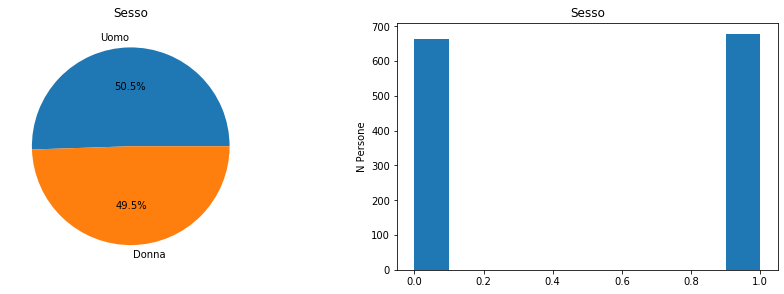

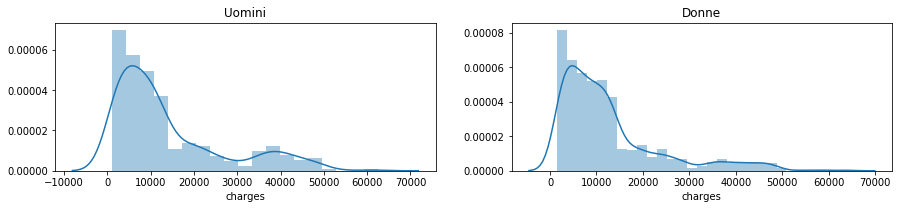

In [14]:
plt.figure(figsize=(15, 10))
# Distribuzione dei sessi
plt.subplot(2, 2, 1)
plt.title('Sesso')
plt.pie(data.sex.value_counts(), autopct='%1.1f%%', labels=['Uomo','Donna']);
plt.subplot(2, 2, 2)
plt.title('Sesso')
plt.ylabel('N Persone')
plt.hist(data.sex);
# Grafici di distribuzione
man = data.loc[data.sex == 1]
woman = data.loc[data.sex == 0]
plt.figure(figsize=(15,6))
sns.distplot(man['charges'], ax=plt.subplot(2,2,3)).set_title(label='Uomini')
sns.distplot(woman['charges'], ax=plt.subplot(2,2,4)).set_title(label='Donne');
data.sex.value_counts()

- Uomini e donne sono praticamente in egual numero all'interno del dataset
- Si può notare che i costi non sono strettamente correlati al sesso, controlliamo calcolando il coefficiente di correlazione di Pearson

#### `smoker`

0    1064
1     274
Name: smoker, dtype: int64

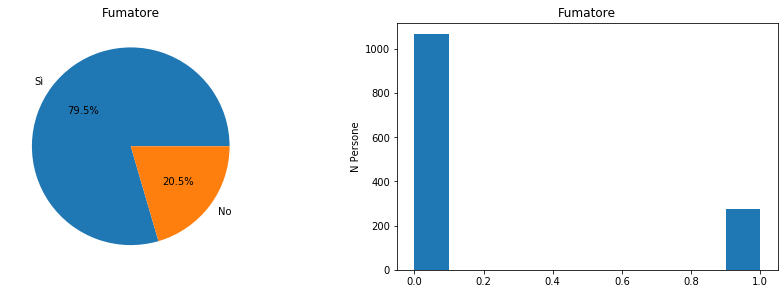

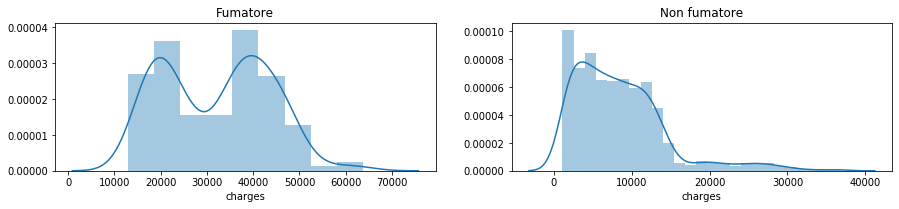

In [15]:
plt.figure(figsize=(15, 10))
# Distribuzione dei fumatori
plt.subplot(2, 2, 1)
plt.title('Fumatore')
plt.pie(data.smoker.value_counts(), autopct='%1.1f%%', labels=['Sì','No']);

plt.subplot(2, 2, 2)
plt.title('Fumatore')
plt.ylabel('N Persone')
plt.hist(data.smoker)

smoke = data.loc[data.smoker == 1]
not_smoke = data.loc[data.smoker == 0]
plt.figure(figsize=(15,6))
sns.distplot(smoke['charges'], ax=plt.subplot(2,2,3)).set_title(label='Fumatore')
sns.distplot(not_smoke['charges'], ax=plt.subplot(2,2,4)).set_title(label='Non fumatore');
data.smoker.value_counts()


- Nel dataset sono presenti molti più persone fumatrici che non
- Per quanto riguarda la feature `smoker`, sembra esserci una forte correlazione fra l'aumento del costo e un paziente fumatore

In [16]:
correlation(insurance.smoker, data.charges)

0.7866630512529551

- Effettivamente è risultato un coefficiente prossimo all'1, indicando quindi una correlazione importante

#### `region`

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

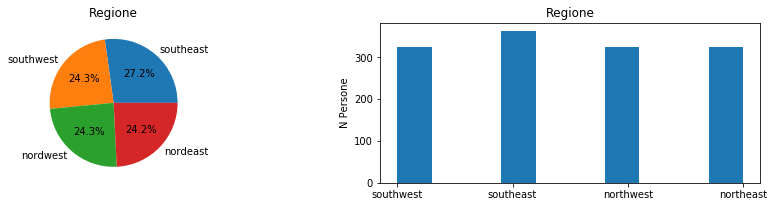

In [17]:
plt.figure(figsize=(15, 10))
# Distribuzione delle regioni
plt.subplot(3, 2, 1)
plt.title('Regione')
plt.pie(insurance.region.value_counts(), autopct='%1.1f%%', labels=[ 'southeast', 'southwest', 'nordwest', 'nordeast']);
plt.subplot(3, 2, 2)
plt.title('Regione')
plt.ylabel('N Persone')
plt.hist(insurance.region);

insurance.region.value_counts()

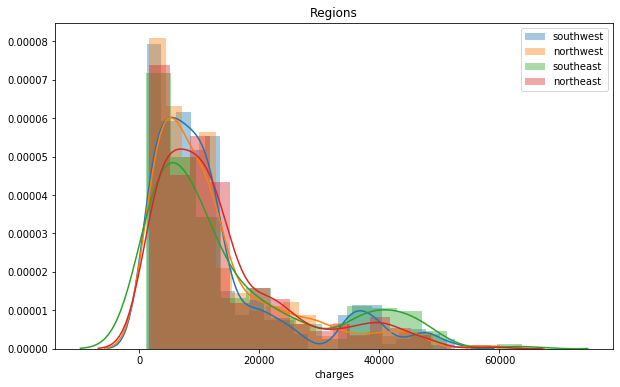

In [18]:
southwest = insurance.loc[insurance.region == 'southwest']
northwest = insurance.loc[insurance.region == 'northwest']
southeast = insurance.loc[insurance.region == 'southeast']
northeast = insurance.loc[insurance.region == 'northeast']
plt.figure(figsize=(10, 6))
sns.distplot(southwest['charges'], label='southwest').set_title(label='Regions')
sns.distplot(northwest['charges'], label='northwest')
sns.distplot(southeast['charges'], label='southeast')
sns.distplot(northeast['charges'], label='northeast')
plt.legend();

- È chiaro come non ci sia una forte correlazione fra l'aumento del costo e le varie regioni statunitensi

- Dallo studio delle variabili categoriche possiamo capire come solamente la feature `smoker` abbia un impatto importante nella determinazione della variabile `charges`.
- Passiamo ora alle variabili continue.

### Variabili continue

#### `age`

18    69
19    68
Name: age, dtype: int64

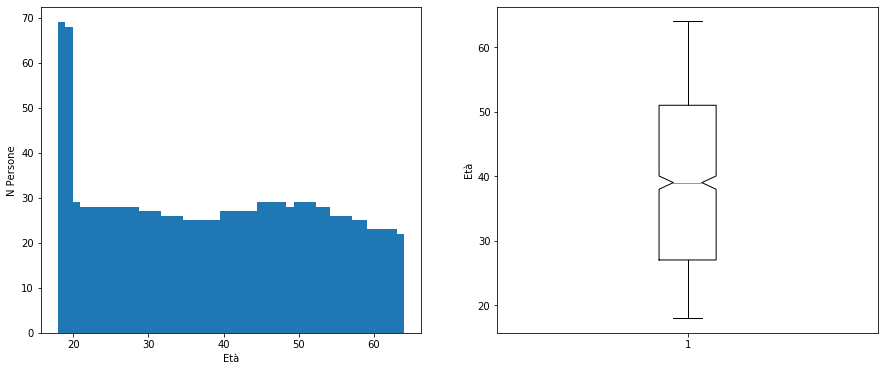

In [19]:
plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
plt.hist(data.age, bins=47)
plt.ylabel('N Persone')
plt.xlabel('Età')

plt.subplot(1,2,2)
plt.ylabel('Età')
plt.boxplot(data.age, notch=True)
data.loc[data.age < 20].age.value_counts()

- Come si può notare dal grafico, si ha una distribuzione dell'età equa delle sottoscrizioni dell'assicurazione medica
- Fatta eccezione per i contraenti con 18 e 19 anni
- Un'età maggiore influenzerà il costo?

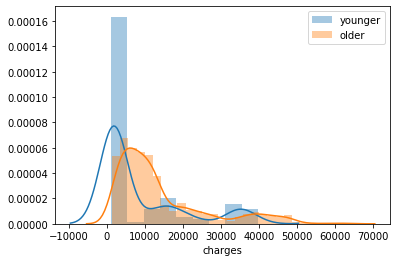

In [20]:
sns.distplot(data.loc[data.age <= 19 ]['charges'])
sns.distplot(data.loc[data.age > 19]['charges'])
plt.legend(['younger', 'older']);

- Una maggiore età sicuramente influenza il minimo della nostra variabile obiettivo, ma non la influenza globalmente.
- Ci aspettiamo un coefficiente di correlazione superiore allo 0 ma non molto alto, data la non generale correlazione

In [21]:
correlation(data.age, data.charges)

0.29878471934460105

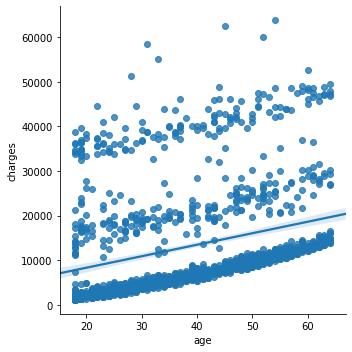

In [22]:
sns.lmplot(x='age',y='charges',data=data);

#### `bmi`
- L'indice di massa corporea è rappresentativo della fisicità ($\frac{Altezza}{peso^2}$) di una persona
- Il BMI influenzerà il costo sanitario?

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


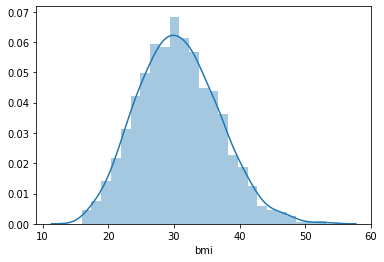

In [23]:
sns.distplot(data.bmi);
data.describe()

- La maggioranza delle persone prese in esame ha un BMI superiore a `24.9`, indice massimo del normopeso
- La media è 30, indice di obesità
- Solamente una piccola parte delle persone prese in esame ha una condizione ottimale di BMI (19<BMI<25)
- Si può nuotare come la curva tenda leggermente verso BMI altissimi (>50) per la presenza di valori limite

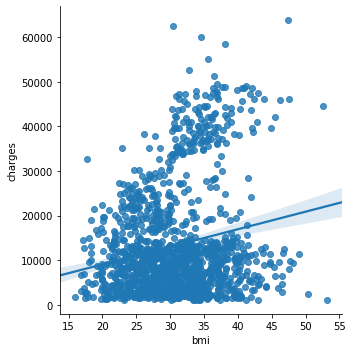

In [24]:
sns.lmplot(x='bmi', y='charges', data=data);

- Si può già notare come un BMI superiore al normopeso possa essere indice di un aumento del costo dell'assicurazione
- Andiamo a studiare nel dettaglio il costo per chi è entro il normopeso e per chi non lo è

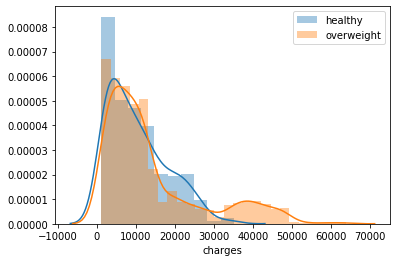

In [25]:
healthy = data.loc[data.bmi < 25]
overweight = data.loc[data.bmi >= 25]

sns.distplot(healthy['charges'])
sns.distplot(overweight['charges'])
plt.legend(['healthy', 'overweight']);

- Un BMI superiore al normopeso si concretalizza in un costo non generalmente più alto
- Vediamo però che c'è un numero ampiamente maggiore di pazienti sovrappeso con un costo più alto, probabile però che questo aumento sia dovuto al fatto che quelle persone siano anche fumatrici
- Ci dovremmo aspettare quindi una bassa correlazione fra l'indice di massa corporea e il costo e piuttosto una presenza di pazienti con alto bmi e fumatori

In [26]:
correlation(data.bmi, data.charges)

0.19819273193614506

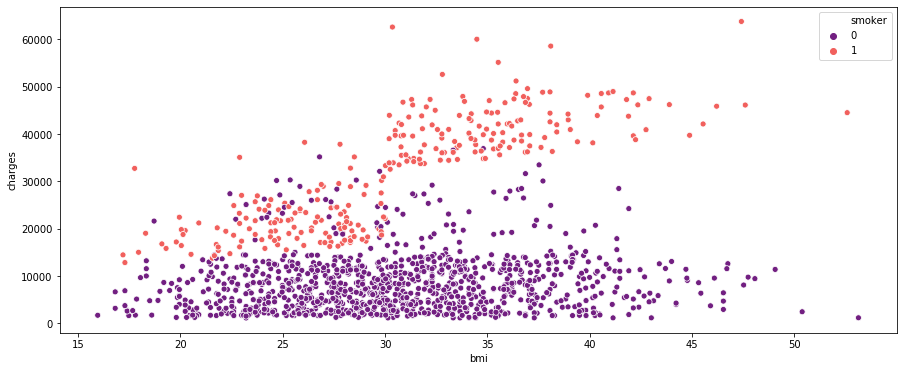

In [27]:
plt.figure(figsize=(15,6))
sns.scatterplot(x='bmi',y='charges',data=data,palette='magma',hue='smoker');

- Il grafico ci conferma come costi più alti non dipendano direttamente dal BMI ma dal fatto che ci siano molti fumatori con un BMI sopra la media

### Variabile discreta `children`

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

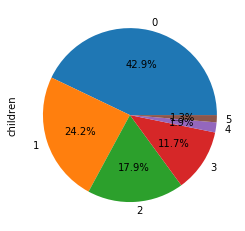

In [28]:
data['children'].value_counts().plot.pie(autopct='%1.1f%%');
data['children'].value_counts()

- La maggiorparte dei soggetti non ha figli (42.9%)
- Una minima parte dei soggetti ha fra i 3 e i 5 figli (<15%)

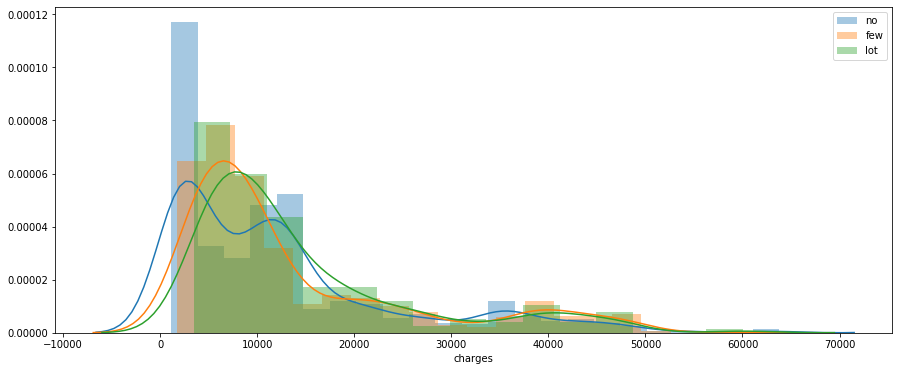

In [29]:
plt.figure(figsize=(15, 6))
no_children = data.loc[data.children == 0]
few_children = data.loc[(data.children > 0) & (data.children < 3)]
lot_children = data.loc[data.children >= 3]
sns.distplot(no_children['charges'])
sns.distplot(few_children['charges'])
sns.distplot(lot_children['charges'])
plt.legend(['no', 'few', 'lot']);

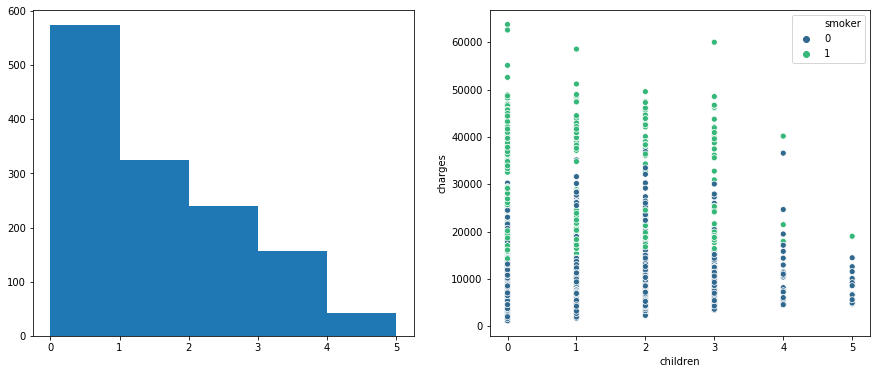

In [30]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
#plt.scatter(data.children, data.charges)
#plt.subplot(1,2,2)
plt.hist(data.children, bins=5);

plt.subplot(1,2,2)
sns.scatterplot(x='children',y='charges',data=data,palette='viridis',hue='smoker');

- Il numero di figli non sembra far aumentare i costi direttamente, piuttosto un aumento molto leggero del minimo valore della nostra variabile obiettivo
- Di conseguenza, ci aspettiamo un coefficiente di correlazione prossimo allo 0

In [31]:
correlation(data.children, data.charges)

0.0679474060505599

- Come dimostra l'indice di correlazione, anche in questo caso i costi maggiori sono dovuti solamente al fatto che una persona sia fumatrice

### Variabile obiettivo `charges`

- Ora osserviamo l'andamento e la distribuzione della nostra variabile dipendente

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

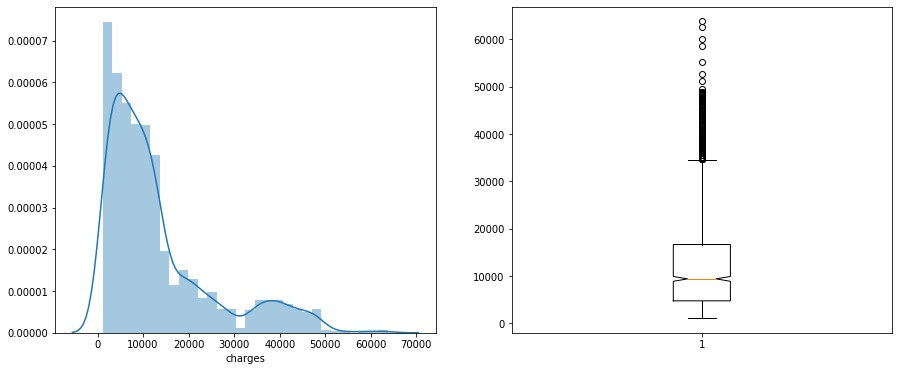

In [32]:
plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
#plt.hist(data.charges, bins=100)
sns.distplot(data.charges)

plt.subplot(1,2,2)
plt.boxplot(data.charges, notch=True);
data.charges.describe()

- La nostra variabile obiettivo ha un andamento poco omogeneo, con valori molto frequenti nella parte bassa.
- Infatti, come ci indica anche la mediana, il 50% dei valori è inferiore a 9301

## Matrice di correlazione

- Costruiamo una matrice con tutti gli indici di correlazione analizzati fino ad ora per avere uno sguardo d'insieme sulle variabili
- È utile anche per vedere se sono presenti collinearità fra le features

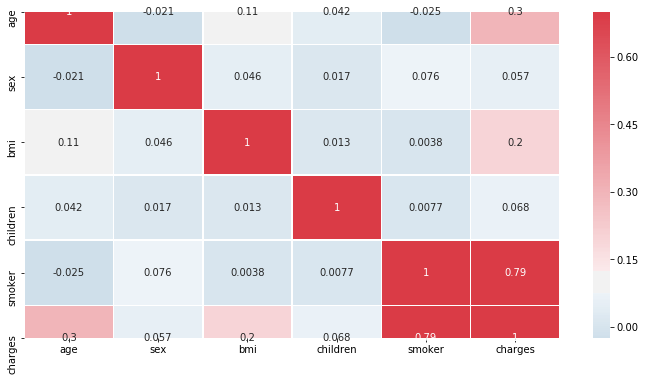

In [33]:
plt.figure(figsize=(12,6))
sns.heatmap(
            # matrice di correlazione
            insurance.corr(),
            # color map
            cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True),
            # Annotazione sulla casella
            annot = True,
            # valore massimo e minimo
            vmax=.7,
            # larghezza delle linee
            linewidths=.5,
            # 
            center=.1
);

- La matrice delle correlazioni ci conferma quanto visto finora
- Possiamo notare come non ci siano particolari correlazioni fra le features, non abbiamo quindi variabili collineari

## Preparazione dei dati

- È finalmente arrivato il momento di cercare un modello di conoscenza adatto a predire la nostra variabile `charges`, iniziamo preparando i dati
- Estraiamo dal nostro dataset
    - La Series `y` contenente i valori della colonna `charges` da predire
    - Il DataFrame `X` con i valori di tutte le altre colonne, utili per la predizione

In [34]:
y = data['charges']
X = data.drop(columns='charges')

In [35]:
y

0       16884.92400
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
1337    29141.36030
Name: charges, Length: 1338, dtype: float64

In [36]:
X

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,0,0,0,1
1,18,1,33.770,1,0,0,0,1,0
2,28,1,33.000,3,0,0,0,1,0
3,33,1,22.705,0,0,0,1,0,0
4,32,1,28.880,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,0,1,0,0
1334,18,0,31.920,0,0,1,0,0,0
1335,18,0,36.850,0,0,0,0,1,0
1336,21,0,25.800,0,0,0,0,0,1


- Dividiamo il dataset in training e validation set attraverso il metodo _hold out_
- Utilizziamo la funzione _train_test_split_

In [37]:
X_train_full, X_val_full, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

## Modelli

In [38]:
# definisco funzione per errore relativo
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

# funzione per stampare i tre indici MSE, RE, R2 e per renderizzare il grafico
def print_eval(model, plot=True):
    preds = model.predict(X_val)
    if plot == True:
        # grafico per vedere l'andamento delle predizioni rispetto ai valori reali
        plt.figure(figsize=(10, 4))
        sns.distplot(preds, hist=False, label='preds')
        sns.distplot(y_val, hist=False, label='y_val')
        plt.legend()
    # stampa mse, re, r2
    mse = mean_squared_error(y_val, preds)
    re = relative_error(y_val, preds)
    r2 = model.score(X_val, y_val)*100
    print("   Mean squared error: {:.5}".format(mse))
    print("       Relative error: {:.5%}".format(re))
    print('R^2|Accuracy on train: {:.2f}%'.format(model.score(X_train, y_train)*100))
    print('R^2|  Accuracy on val: {:.2f}%'.format(r2))
    return mse, re, r2

# funzione per salvare i risultati dei vari modelli in un unico DF, utile per il confronto alla fine
results = pd.DataFrame(data={}, columns=['model', 'mse', 're', 'r2'])
def save_results(name='-', mse=0, re=0, r2=0):
    data = {'model': [name], 'mse': [mse], 're': [re], 'r2': [r2]}
    global results
    results = results.append(pd.DataFrame(data), ignore_index=True)

# definisco i fold per la cross validation
kf = KFold(5, shuffle=True, random_state=42)

- Per prima cosa, studiamo se utilizzando la regressione Lasso siamo in grado di eliminare, grazie alla regolarizzazione L1, qualche feature poiché poco rilevante

### Regressione Lasso

In [39]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("reg", Lasso())
])
grid = {'reg__alpha' : [1, 10, 100]}
gs = GridSearchCV(model, grid, cv=kf)
gs.fit(X_train_full, y_train)
print('Best params: ', gs.best_params_)
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

Best params:  {'reg__alpha': 100}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.007580,0.000488,0.002593,0.000489,100,{'reg__alpha': 100},0.793709,0.702722,0.753807,0.762435,0.689176,0.740387,0.038878,1
1,0.007184,0.000247,0.002593,0.000489,10,{'reg__alpha': 10},0.794374,0.702791,0.755244,0.760163,0.686981,0.739930,0.039491,2
0,0.008577,0.001620,0.002593,0.000488,1,{'reg__alpha': 1},0.794372,0.702783,0.755389,0.759915,0.686799,0.739871,0.039527,3


- Il risultato migliore si ha con un lambda pari a 100, vediamo se con questa regolarizzazione abbiamo ridotto a zero qualche coefficiente

In [40]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("reg", Lasso(alpha=100))
])
model.fit(X_train_full, y_train)
pd.Series(model.named_steps["reg"].coef_, X.columns)

age                 3630.825790
sex                    0.000000
bmi                 1926.756391
children             359.827309
smoker              9494.548394
region_northeast     157.793253
region_northwest       0.000000
region_southeast     -39.895440
region_southwest     -30.558417
dtype: float64

- Possiamo constatare che le variabili `sex` e `region_northwest` sono state ridotte a zero con la norma L1
- Possiamo quindi eliminarle dal dataset

In [41]:
X_train = X_train_full.drop(columns=['sex', 'region_northwest'])
X_val = X_val_full.drop(columns=['sex', 'region_northwest'])
Xd = X.drop(columns=['sex', 'region_northwest'])

### Regressione Lineare

- Testiamo inizialmente un semplice modello di regressione lineare senza normalizzazione delle variabili

   Mean squared error: 3.4924e+07
       Relative error: 43.26652%
R^2|Accuracy on train: 74.31%
R^2|  Accuracy on val: 76.53%


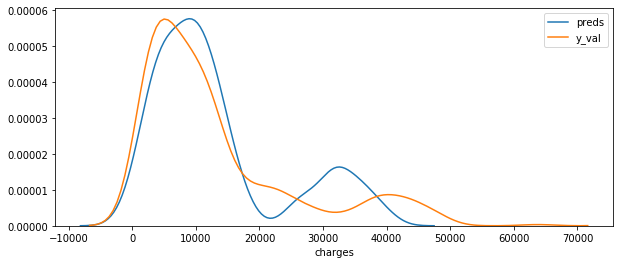

In [42]:
model = LinearRegression()
model.fit(X_train, y_train)
mse, re, r2 = print_eval(model)
save_results('LinReg', mse, re, r2)

- Anche la semplice regressione lineare dà buoni risultati
- Proviamo ora a normalizzare i dati utilizzando lo _StandardScaler_, anche se, visti i valori dei dati molto bassi e omogenei, sicuramente non ci saranno differenze notevoli

   Mean squared error: 3.4924e+07
       Relative error: 43.26652%
R^2|Accuracy on train: 74.31%
R^2|  Accuracy on val: 76.53%


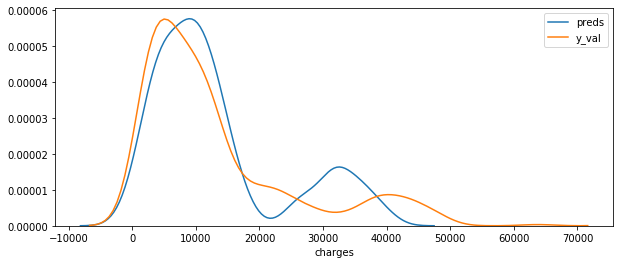

In [43]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])
model.fit(X_train, y_train)
model.score(X_val, y_val)
mse, re, r2 = print_eval(model)
save_results('LinRegScale', mse, re, r2)

### Regressione Polinomiale

   Mean squared error: 2.1048e+07
       Relative error: 27.80217%
R^2|Accuracy on train: 83.95%
R^2|  Accuracy on val: 85.86%


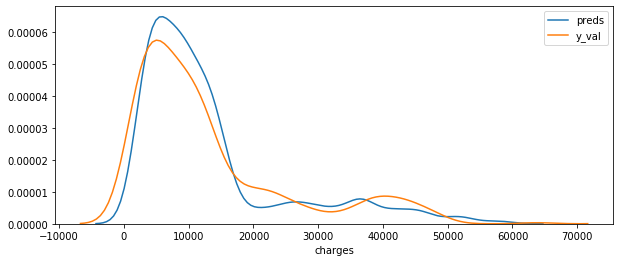

In [44]:
model = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('reg', LinearRegression())
])
model.fit(X_train, y_train)
mse, re, r2 = print_eval(model)
save_results('Poly', mse, re, r2)

   Mean squared error: 2.1048e+07
       Relative error: 27.80217%
R^2|Accuracy on train: 83.95%
R^2|  Accuracy on val: 85.86%


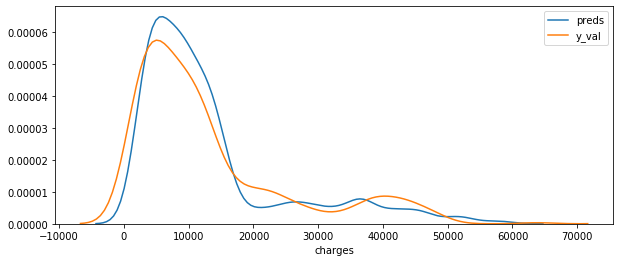

In [45]:
model = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])
model.fit(X_train, y_train)
mse, re, r2 = print_eval(model)
save_results('PolyScale', mse, re, r2)

- Ora controlliamo se ci sia possibilità di migliorare ancora il modello con un grado polinomiale più alto

In [46]:
model = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])
grid = {
    'poly__degree': range(1, 10)
    }
gs = GridSearchCV(model, grid, cv=kf)
gs.fit(X_train, y_train)
print('Best params: ', gs.best_params_)
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

Best params:  {'poly__degree': 2}


G:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.007181,0.000746,0.002394,0.000489,2,{'poly__degree': 2},8.834185e-01,7.917944e-01,8.439778e-01,8.673501e-01,7.698595e-01,8.312943e-01,4.362328e-02,1
2,0.010774,0.000509,0.003590,0.000489,3,{'poly__degree': 3},8.729298e-01,7.845448e-01,8.312841e-01,8.368614e-01,7.524001e-01,8.156335e-01,4.230171e-02,2
3,0.032016,0.002239,0.006782,0.000747,4,{'poly__degree': 4},8.616734e-01,6.371085e-01,7.930824e-01,8.000334e-01,7.135043e-01,7.610542e-01,7.793314e-02,3
0,0.007283,0.000872,0.002394,0.000488,1,{'poly__degree': 1},7.946417e-01,7.052064e-01,7.553369e-01,7.612769e-01,6.867034e-01,7.406539e-01,3.931622e-02,4
4,0.081183,0.002570,0.012674,0.001430,5,{'poly__degree': 5},6.605534e-01,-9.494218e+00,-5.012339e-01,-9.828349e-02,-5.249456e-01,-1.997063e+00,3.780875e+00,5
5,0.167661,0.007200,0.024139,0.002517,6,{'poly__degree': 6},-1.330042e+05,-2.830185e+07,-7.913673e+05,-1.518922e+15,-1.435192e+07,-3.031033e+14,6.070574e+14,6
6,0.263009,0.003132,0.041391,0.000629,7,{'poly__degree': 7},-2.417456e+13,-4.238560e+12,-4.288696e+05,-1.413918e+15,-2.686632e+14,-3.414636e+14,5.448520e+14,7
7,0.479971,0.004467,0.080391,0.005222,8,{'poly__degree': 8},-6.608299e+12,-1.352769e+15,-2.159777e+15,-8.323040e+14,-7.323194e+13,-8.844779e+14,8.093680e+14,8
8,0.835940,0.015657,0.145029,0.003056,9,{'poly__degree': 9},-2.581400e+13,-2.426888e+13,-8.973688e+16,-7.039943e+15,-2.956303e+14,-1.938101e+16,3.523087e+16,9


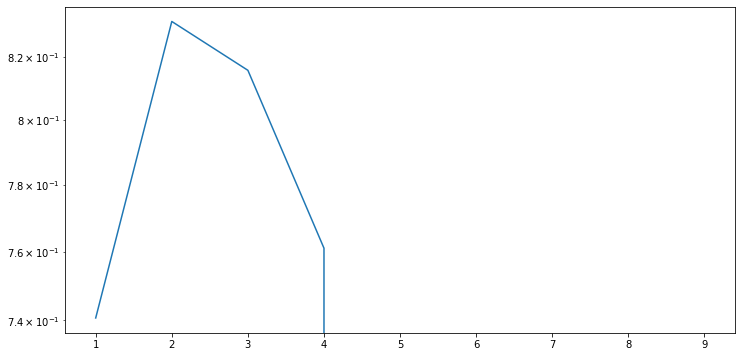

In [47]:
plt.figure(figsize=(12,6))
x_axis = gs.cv_results_['param_poly__degree'].data
y_axis = gs.cv_results_['mean_test_score']
plt.yscale('log')
plt.plot(x_axis, y_axis);

- Possiamo notare come la soluzione migliore sia effettivamente quella con polinomio di grado 2.
- Lo score infatti è minore con grado pari a 1 (il risultato della regressione lineare) e precipita con gradi maggiori a 2

### Regressione Ridge

   Mean squared error: 3.4958e+07
       Relative error: 43.48315%
R^2|Accuracy on train: 74.31%
R^2|  Accuracy on val: 76.51%


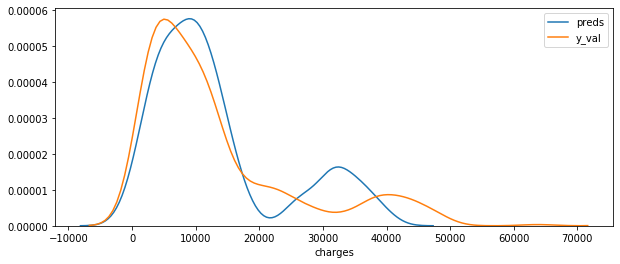

In [48]:
model = Ridge(alpha=1)
model.fit(X_train, y_train)
mse, re, r2 = print_eval(model)
save_results('Ridge', mse, re, r2)

- Finora abbiamo visto che il modello migliore è quello polinomiale, proviamo a introdurre una regolarizzazione utilizzando una funzione Kernel trick di tipo polinomiale alla regressione Ridge
- Ora testiamo, utilizzando la Grid Search e la K Fold Validation, il modello per cercare dei paremetri migliori, se ne esistono
- Testiamo sia la regolarizzazione con kernel polinomiale che con kernel RBF (_Radial Basis Function_)

In [49]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', KernelRidge())
])
grid = {
    'reg__kernel': ['poly'],
    'reg__degree': range(1, 5),
    'reg__alpha': [0.01, 0.1, 1, 10],
    }, {
    'reg__kernel': ['rbf'],
    'reg__alpha': [0.01, 0.1, 1, 10],
    'reg__gamma': [0.01, 0.1, 1, 10]
}
gs = GridSearchCV(model, grid, cv=kf)
gs.fit(X_train, y_train)
print('Best params: ', gs.best_params_)

Best params:  {'reg__alpha': 0.01, 'reg__gamma': 0.01, 'reg__kernel': 'rbf'}


In [50]:
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)[:2]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg__alpha,param_reg__degree,param_reg__kernel,param_reg__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
16,0.024341,0.001455,0.005487,0.000772,0.01,NaN,rbf,0.01,"{'reg__alpha': 0.01, 'reg__gamma': 0.01, 'reg_...",0.884132,0.794405,0.846970,0.868332,0.769767,0.832736,0.043697,1
9,0.019646,0.000979,0.002792,0.000747,1,2,poly,NaN,"{'reg__alpha': 1, 'reg__degree': 2, 'reg__kern...",0.883411,0.792419,0.843822,0.867742,0.770831,0.831659,0.043291,2


- La grid search ci indica che il risultato migliore si ottiene con kernel rbf
- Però anche la soluzione con kernel poly non si discosta molto, testiamole entrambe con Cross Validation

   Mean squared error: 2.0592e+07
       Relative error: 27.74555%
R^2|Accuracy on train: 84.46%
R^2|  Accuracy on val: 86.16%


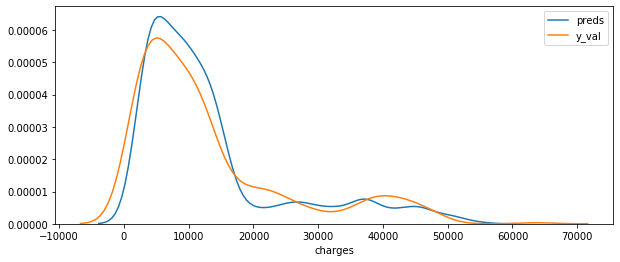

In [51]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', KernelRidge(kernel='rbf', gamma=0.01, alpha=0.01))
])
model.fit(X_train, y_train)
mse, re, r2 = print_eval(model)
save_results('KernelRBF', mse, re, r2)

   Mean squared error: 2.1047e+07
       Relative error: 27.80421%
R^2|Accuracy on train: 83.95%
R^2|  Accuracy on val: 85.86%


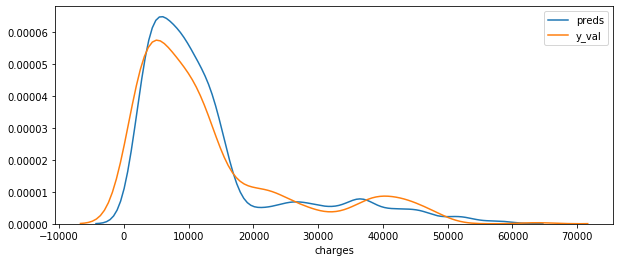

In [52]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', KernelRidge(kernel='poly', degree=2, alpha=0.01))
])
model.fit(X_train, y_train)
mse, re, r2 = print_eval(model)
save_results('KernelPoly', mse, re, r2)

## Confronto e scelta dei modelli

In [53]:
results.sort_values('r2', ascending=False)

,model,mse,re,r2
5,KernelRBF,2.059232e+07,0.277455,86.162947
6,KernelPoly,2.104738e+07,0.278042,85.857170
2,Poly,2.104753e+07,0.278022,85.857068
3,PolyScale,2.104753e+07,0.278022,85.857068
0,LinReg,3.492366e+07,0.432665,76.532972
1,LinRegScale,3.492366e+07,0.432665,76.532972
4,Ridge,3.495762e+07,0.434832,76.510154


In [54]:
results.sort_values('re')

,model,mse,re,r2
5,KernelRBF,2.059232e+07,0.277455,86.162947
3,PolyScale,2.104753e+07,0.278022,85.857068
2,Poly,2.104753e+07,0.278022,85.857068
6,KernelPoly,2.104738e+07,0.278042,85.857170
0,LinReg,3.492366e+07,0.432665,76.532972
1,LinRegScale,3.492366e+07,0.432665,76.532972
4,Ridge,3.495762e+07,0.434832,76.510154


- A questo punto, notiamo come i modelli migliori siano:
    - `KernelRBF`
    - `KernelPoly`
- Hanno entrambi un ottimo score a fronte di un errore minore rispetto agli altri
- Il modello addestrato attraverso una regressione polinomiale mediante funzione kernel ha un errore impercettibilmente maggiore (~0.00002) delle sue varianti non calcolate mediante funzione kernel, ma ha il vantaggio di avere un costo computazionale certamente minore anche se poco apprezzabile al grado 2

Per scrupolo, controlliamo e confrontiamo i risultati utilizzando il modello scelto senza togliere le variabili ritenute irrilevanti con la regolarizzazione L1

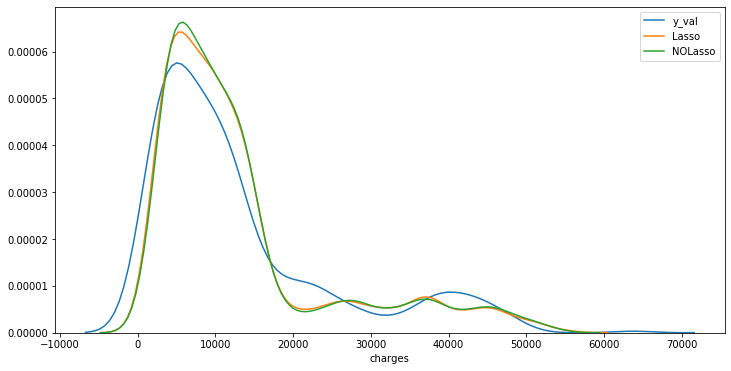

In [55]:
# Lasso
model = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', KernelRidge(kernel='rbf', gamma=0.01, alpha=0.01))
])
model.fit(X_train, y_train)
preds = model.predict(X_val)
plt.figure(figsize=(12,6))
sns.distplot(y_val, hist=False, label='y_val')
sns.distplot(preds, hist=False, label='Lasso')

# No Lasso
model1 = model = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', KernelRidge(kernel='rbf', gamma=0.01, alpha=0.01))
])
model1.fit(X_train_full, y_train)
preds1 = model1.predict(X_val_full)
sns.distplot(preds1, hist=False, label='NOLasso')
plt.legend();

- Possiamo effettivamente notare come il modello calcolato eliminando le features irrilevanti si dimostri generalmente più accurato, anche se di poco
- Nel punto di massimo si nota come il discostamento del modello senza features irrilevanti si dimostri più preciso

- Scegliamo quindi di tenere in considerazione, per la valutazione, solamente:
    - `KernelRBF`
    - `KernelPoly` 

### Valutazione del modello

- Ora valutiamo i modelli attraverso l'impiegio della _nested cross-validation_

In [56]:
# definiamo le dimensioni dei k fold esterni ed interni
outer_cv = KFold(3, shuffle=True, random_state=42)
inner_cv = KFold(5, shuffle=True, random_state=42)
# funzione per la nested cross validation
def nested_cv(model):
    results = []
    for train_indices, val_indices in outer_cv.split(Xd, y):
        cv_results = cross_validate(model, Xd.iloc[train_indices], y.iloc[train_indices], cv=inner_cv)
        score = {'mean': cv_results['test_score'].mean(), 'std': cv_results['test_score'].std()}
        results.append(score)
    return results

In [57]:
rbf = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', KernelRidge(kernel='rbf', gamma=0.01, alpha=0.01))
])
nested_cv(rbf)

[{'mean': 0.8262733802907091, 'std': 0.038144036627187385},
 {'mean': 0.8285898651064907, 'std': 0.03798311622120956},
 {'mean': 0.8500594100329939, 'std': 0.04351959313843432}]

In [58]:
poly = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', KernelRidge(kernel='poly', degree=2, alpha=0.01))
])
nested_cv(poly)

[{'mean': 0.8234220387008883, 'std': 0.03963980516959848},
 {'mean': 0.8258724459557666, 'std': 0.03934712706988169},
 {'mean': 0.8484944729356518, 'std': 0.04192895525893732}]

In [59]:
def diff_interval(a1, a2, N1, N2, Z):
    d = abs(a1 - a2)
    sd = np.sqrt(a1 * (1-a1) / N1 + a2 * (1-a2) / N2)
    return d - Z * sd, d + Z * sd
def model_diff_interval(m1, m2, X, y, level=0.95):
    a1 = m1.score(X, y)
    a2 = m2.score(X, y)
    N = len(X)
    Z = norm.ppf((1 + level) / 2)
    return diff_interval(a1, a2, N, N, Z)

In [60]:
rbf.fit(X_val, y_val)
poly.fit(X_val, y_val)
model_diff_interval(rbf, poly, X_val, y_val, 0.95)

(-0.04005991569292939, 0.04853731165428383)

In [61]:
model_diff_interval(rbf, poly, X_val, y_val, 0.14)

(0.0002523334100721494, 0.008225062551282289)

- Visto che l'intervallo contiene lo 0 possiamo dire che la differenza di accuratezza al 95% fra i due modelli non è significativa, cioè non abbiamo la certezza al 95% che il modello rbf sia effettivamente migliore
- Solamente con un livello di confidenza pari al 14% possiamo dire che il modello rbf è migliore del polinomiale
- Quindi possiamo dire che i due modelli sono praticamente equivalenti, come anche dimostrato dal confronto di $R^2$ e $MSE$
- Per concludere, mostriamo in un grafico i due modelli

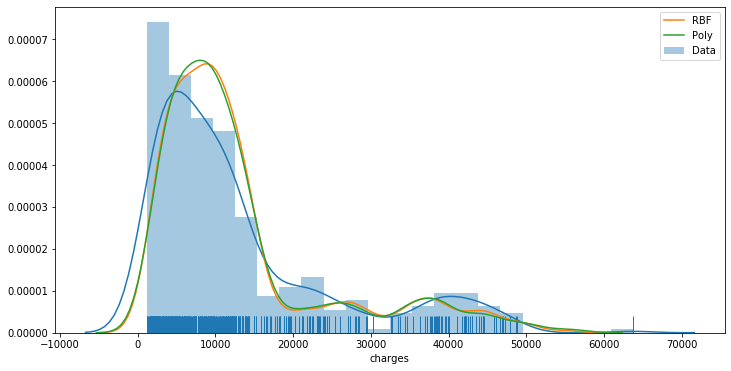

In [62]:
plt.figure(figsize=(12,6))
sns.distplot(y_val, rug=True, label='Data')

# RBF
rbf_preds = rbf.predict(X_val)
sns.distplot(rbf_preds, hist=False,label='RBF')

# Poly
poly_preds = poly.predict(X_val)
sns.distplot(poly_preds, hist=False, label='Poly')
plt.legend();